Import libraries

In [150]:
import pandas as pd
import numpy as np
import re
from pyvi.ViTokenizer import ViTokenizer
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.layers import Dense, ReLU
from tensorflow.keras.layers import Embedding, BatchNormalization, Concatenate
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.optimizers.legacy import Adam

Load data

In [151]:
import pandas as pd 
import numpy as np 

TRAIN_DATA = '../data/ViCTSD/ViCTSD_train.csv'
DEV_DATA = '../data//ViCTSD/ViCTSD_valid.csv'
TEST_DATA = '../data/ViCTSD/ViCTSD_test.csv'

# read data
train_data = pd.read_csv(TRAIN_DATA)
dev_data = pd.read_csv(DEV_DATA)
test_data = pd.read_csv(TEST_DATA)

train_data = train_data.dropna(subset=['Comment'])
dev_data = dev_data.dropna(subset=['Comment'])
test_data = test_data.dropna(subset=['Comment'])


print(len(train_data))
print(len(dev_data))
print(len(test_data))

7000
2000
1000


Data preprocessing

In [152]:
# def load_teencode_dict(file_path):
#     teencode_dict = {}
#     with open(file_path, 'r', encoding='utf-8') as file:
#         for line in file:
#             if line.strip():  # Kiểm tra xem dòng không phải là dòng trống
#                 teencode, full_word = line.strip().split('\t')
#                 teencode_dict[teencode] = full_word
#     return teencode_dict
# # Đường dẫn tới file teencode.txt
# teencode_file = '../data/teencode.txt'

# # Tải từ điển teen code
# teencode_dict = load_teencode_dict(teencode_file)

# def replace_teencode(text, teencode_dict = teencode_dict):
#     words = text.split()
#     new_words = [teencode_dict.get(word, word) for word in words]
#     return ' '.join(new_words)

# # Đoạn text cần kiểm tra và thay thế
# text = "mih qtam cta r svtn"
# new_text = replace_teencode(text)

# print(new_text)

In [153]:
STOPWORDS = '../data/vietnamese-stopwords-dash.txt'
stopwords = []

with open(STOPWORDS, "r") as ins:
    for line in ins:
        dd = line.strip('\n')
        stopwords.append(dd)
    stopwords = set(stopwords)

def filter_stop_words(train_sentences, stop_words):
    new_sent = [word for word in train_sentences.split() if word not in stop_words]
    train_sentences = ' '.join(new_sent)
        
    return train_sentences

def deEmojify(text):
    # remove emoji
    emoji_pattern = re.compile(
        pattern = "["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
            u"\U00002702-\U000027B0"  # Dingbats
            u"\U000024C2-\U0001F251"  # Enclosed characters
            u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
            u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
            u"\U0000200D"              # Zero Width Joiner
            u"\U0000200C"              # Zero Width Non-Joiner
            "]+", 
        flags = re.UNICODE
    )

    text = emoji_pattern.sub(r'', text)  
    return text

def deSpecialCharacters(text):
    text =  re.sub('\W+',' ', text )
    return text

def preprocess(text, tokenized = True, lowercased = True):
    text = deEmojify(text)
    text = deSpecialCharacters(text)
    text = re.sub(r'\s+', ' ', text).strip() 
    text = text.lower() if lowercased else text
    # text = replace_teencode(text)
    text = ViTokenizer.tokenize(text) if tokenized else text
    text = filter_stop_words(text, stopwords)# text = filter_stop_words(text, stopwords)
    return text

In [154]:
train_data['Comment'] = train_data['Comment'].apply(preprocess)
test_data['Comment'] = train_data['Comment'].apply(preprocess)
dev_data['Comment'] = train_data['Comment'].apply(preprocess)
train_data = train_data[train_data['Comment'] != '']
test_data = test_data[test_data['Comment'] != '']
dev_data = dev_data[dev_data['Comment'] != '']

In [155]:
tr_text = train_data['Comment']
tr_label = train_data['Toxicity']

val_text = dev_data['Comment']
val_label = dev_data['Toxicity']

ts_text = test_data['Comment']
ts_label = test_data['Toxicity']

Feature

In [156]:
vocabulary_size = 10000
sequence_length = 100
tokenizer = Tokenizer(num_words=vocabulary_size)
tokenizer.fit_on_texts(tr_text) 
                            
sequences = tokenizer.texts_to_sequences(tr_text)

tr_x = pad_sequences(sequences, maxlen=sequence_length) 
tr_y = to_categorical(tr_label, num_classes=2)

sequences = tokenizer.texts_to_sequences(val_text)
val_x = pad_sequences(sequences, maxlen=sequence_length)
val_y = to_categorical(val_label, num_classes=2)

sequences = tokenizer.texts_to_sequences(ts_text)
ts_x = pad_sequences(sequences, maxlen=sequence_length)
ts_y = to_categorical(ts_label, num_classes=2)

note

Run model

In [157]:
max_words = 10000
max_len = 100
embedding_dim = 32

In [158]:
# Branch 1
branch1 = Sequential()
branch1.add(Embedding(max_words, embedding_dim, input_length=max_len))
branch1.add(Conv1D(64, 3, padding='same', activation='relu'))
branch1.add(BatchNormalization())
branch1.add(ReLU())
branch1.add(Dropout(0.3))
branch1.add(GlobalMaxPooling1D())

# Branch 2
branch2 = Sequential()
branch2.add(Embedding(max_words, embedding_dim, input_length=max_len))
branch2.add(Conv1D(64, 3, padding='same', activation='relu'))
branch2.add(BatchNormalization())
branch2.add(ReLU())
branch2.add(Dropout(0.3))
branch2.add(GlobalMaxPooling1D())

concatenated = Concatenate()([branch1.output, branch2.output])

hid_layer = Dense(128, activation='relu')(concatenated)
dropout = Dropout(0.2)(hid_layer)
output_layer = Dense(2, activation='softmax')(dropout)

model = Model(inputs=[branch1.input, branch2.input], outputs=output_layer)

In [159]:
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 embedding_22_input (InputL  [(None, 100)]                0         []                            
 ayer)                                                                                            
                                                                                                  
 embedding_23_input (InputL  [(None, 100)]                0         []                            
 ayer)                                                                                            
                                                                                                  
 embedding_22 (Embedding)    (None, 100, 32)              320000    ['embedding_22_input[0][0]']  
                                                                                           

c:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\optimizers\legacy\adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [160]:
# early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True,min_delta=0.001)
class_weights = {0: 1.0, 1: 3.0}
batch_size = 256
epochs = 25 # 40, 25
history = model.fit([tr_x, tr_x], tr_y, epochs=epochs, batch_size=batch_size,
                    validation_data=([val_x, val_x], val_y),
                    # callbacks=[early_stopping],
                    class_weight=class_weights
                    )

Epoch 1/25
28/28 [==============================] - 4s 112ms/step - loss: 0.8542 - accuracy: 0.7741 - precision_11: 0.7741 - recall_11: 0.7741 - val_loss: 0.6730 - val_accuracy: 0.8842 - val_precision_11: 0.8842 - val_recall_11: 0.8842
Epoch 2/25
28/28 [==============================] - 3s 108ms/step - loss: 0.7692 - accuracy: 0.8180 - precision_11: 0.8180 - recall_11: 0.8180 - val_loss: 0.6692 - val_accuracy: 0.8842 - val_precision_11: 0.8842 - val_recall_11: 0.8842
Epoch 3/25
28/28 [==============================] - 3s 109ms/step - loss: 0.7153 - accuracy: 0.8448 - precision_11: 0.8448 - recall_11: 0.8448 - val_loss: 0.6659 - val_accuracy: 0.8842 - val_precision_11: 0.8842 - val_recall_11: 0.8842
Epoch 4/25
28/28 [==============================] - 3s 102ms/step - loss: 0.6738 - accuracy: 0.8683 - precision_11: 0.8683 - recall_11: 0.8683 - val_loss: 0.6624 - val_accuracy: 0.8837 - val_precision_11: 0.8837 - val_recall_11: 0.8837
Epoch 5/25
28/28 [==============================] - 3s 1

Save model

In [163]:
import pickle
with open('../models/tokenizer_cnn_cstd.pkl', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

model.save('../models/model_cnn_ctsd.h5')

c:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Evaluation and Visullize results

In [161]:
def evaluation(y_pred, y_test):
    # Tính toán các chỉ số đánh giá
    accuracy  = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1_micro = f1_score(y_test, y_pred, average='micro')
    f1_macro = f1_score(y_test, y_pred, average='macro')

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-micro: {f1_micro}")
    print(f"F1-macro: {f1_macro}")

[[787 100]
 [ 97  13]]
Accuracy: 0.802407221664995
Precision: 0.5026578705001401
Recall: 0.5027211232960951
F1-micro: 0.802407221664995
F1-macro: 0.502677669376831
None


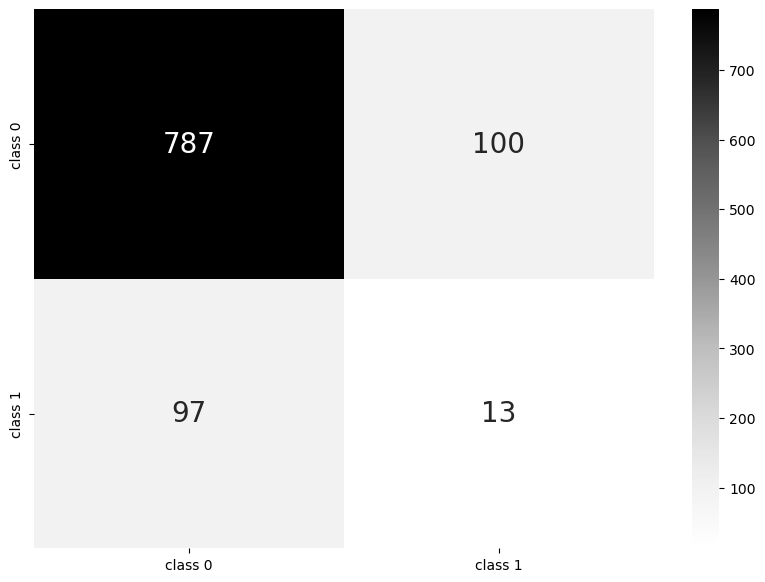

In [162]:
predictions = model.predict([ts_x, ts_x], batch_size=batch_size, verbose=0)
y_pred = predictions.argmax(axis=-1)
y_true = ts_label

# Tính toán confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
print(cf_matrix)

print(evaluation(y_pred, y_true))

# Vẽ confusion matrix
df_cm = pd.DataFrame(cf_matrix, index=["class 0", "class 1"],
                     columns=["class 0", "class 1"])
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, cmap="Greys", fmt='g', cbar=True, annot_kws={"size": 20})
plt.show()